In [1]:
try:
    import serial
    from serial import Serial
except ImportError:
    print("Could not import module: serial")

    
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import sys

# https://reprap.org/wiki/G-code#M17:_Enable.2FPower_all_stepper_motors

In [2]:
def available_serial_ports() -> list:
    """Lists serial port names

    :raises EnvironmentError:
        On unsupported or unknown platforms
    :returns:
        A list of the serial ports available on the system
    """
    if sys.platform.startswith("win"):
        ports = ["COM%s" % (i + 1) for i in range(256)]
    elif sys.platform.startswith("linux") or sys.platform.startswith("cygwin"):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob("/dev/tty[A-Za-z]*")
    elif sys.platform.startswith("darwin"):
        ports = glob.glob("/dev/tty.*")
    else:
        raise EnvironmentError("Unsupported platform")

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

def connect_COM_port(port: str = "COM4", baudrate: int = 115200, timeout: int = 1):
    """
    Etablishes a serial connection to a given com port.
    Returnes the serial connection
    """

    ser = serial.Serial(
        port=port,
        baudrate=baudrate,
        parity=serial.PARITY_NONE,
        stopbits=serial.STOPBITS_ONE,
        bytesize=serial.EIGHTBITS,
    )

    print("Connection to", ser.name, "is established.")
    return ser

In [3]:
available_serial_ports()

['COM1', 'COM4']

In [4]:
#ser = connect_COM_port(port="COM4")

# Printer settings
- Port: COM4
- Baudrate: 115200

In [6]:
## Commands for Ender 5

def move_to_absolute_x(x_abs, F_mm_min:int=1500):
    """
    x_abs : absolute x position
    F_mm_min : movement speed in [mm/min]
    """
    command(ser, f"G0 X{x_abs} F{F_mm_min}\r\n")
    
def move_to_absolute_y(y_abs, F_mm_min:int=1500):
    """
    x_abs : absolute x position
    F_mm_min : movement speed in [mm/min]
    """
    command(ser, f"G0 Y{y_abs} F{F_mm_min}\r\n")
    
def move_to_absolute_z(z_abs, F_mm_min:int=1500):
    """
    x_abs : absolute x position
    F_mm_min : movement speed in [mm/min]
    """
    command(ser, f"G0 Z{z_abs} F{F_mm_min}\r\n")

def move_to_absolute_x_y(x_abs, y_abs, F_mm_min:int=1500):
    """
    x_abs : absolute x position
    y_abs : absolute y position
    F_mm_min : movement speed in [mm/min]
    """
    command(ser, f"G0 X{x_abs} Y{y_abs} F{F_mm_min}\r\n")

def disable_steppers():
    command(ser, "M18 X Y Z E\r\n")
    
def enable_steppers():
    command(ser, "M17 X Y Z E\r\n")
    
def x_y_home(F_mm_min:int=1500):
    command(ser, f"G28 X0 Y0 F{F_mm_min}\r\n")

def x_y_center(F_mm_min:int=1500):
    command(ser, f"G0 X180 Y180 F{F_mm_min}\r\n")
    
def turn_of_fan():
    command(ser, "M106 S0\r\n")
    
def init_axis():
    x_y_home()
    x_y_center()
    turn_of_fan()
    print("X,Y axis are centered at X(180), Y(180)")

def circle_clockwise(X,Y,I=180,J=180, F_mm_min:int=1500, clock:bool=True):
    """
    clock : True = clockwise, False = counter-clockwise
    X : The position to move to on the X axis
    Y : The position to move to on the Y axis
    I : The point in X space from the current X position to maintain a constant distance from
    J : The point in Y space from the current Y position to maintain a constant distance from
    F_mm_min : The feedrate per minute of the move between the starting point and ending point (if supplied)
    """
    if clock:
        command(ser, f"G2 X{X} Y{Y} I{I} J{J} F{F_mm_min}\r\n")
    else:
        command(ser, f"G3 X{X} Y{Y} I{I} J{J} F{F_mm_min}\r\n")
        
def command(ser, command):
    start_time = datetime.now()
    ser.write(str.encode(command)) 
    time.sleep(1)
    while True:
        line = ser.readline()
        print(line)

        if line == b'ok\n':
            break

In [7]:
ser = serial.Serial('COM4', 115200)
time.sleep(1)

In [195]:
# Math commands

def compute_abs_x_y_from_r_phi(r,phi_step)-> np.ndarray:
    """
    Returns a P(x,y) array with the relating trajectory positions.
    Fixpoint/start is the Ender 5 center at P(180,180)
    
    r : absolute radial movement trajectory [mm]
    phi_step : angle step [°]
    
    returns:
        P_xy : Array with x,y steps
    """
    x0,y0 = 180,180
    angles = np.radians(np.arange(0,360,phi_step))
    x = r*np.cos(angles)+x0
    y = r*np.sin(angles)+y0
    print("Number of measurement points:", len(x))
    return x,y

In [196]:
x,y = compute_abs_x_y_from_r_phi(10,10)

Number of measurement points: 36


In [197]:
def plot_x_y_circle(x,y):
    plt.figure(figsize=(8,8))
    plt.xlim((0,350))
    plt.grid()
    plt.vlines(180,0,500,  linestyles='dotted', color="black")
    plt.hlines(180,0,500,  linestyles='dotted', color="black")
    plt.ylim((0,350))
    plt.xlabel("absolute x[mm]")
    
    plt.ylabel("absolute y[mm]")
    plt.scatter(x,y, label="Measurement points", marker='*')
    plt.legend()
    plt.show()

In [198]:
init_axis()

b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'X:360.00 Y:360.00 Z:5.00 E:0.00 Count X:28800 Y:28800 Z:4000\n'
b'ok\n'
b'ok\n'
b'ok\n'
X,Y axis are centered at X(180), Y(180)


Number of measurement points: 18


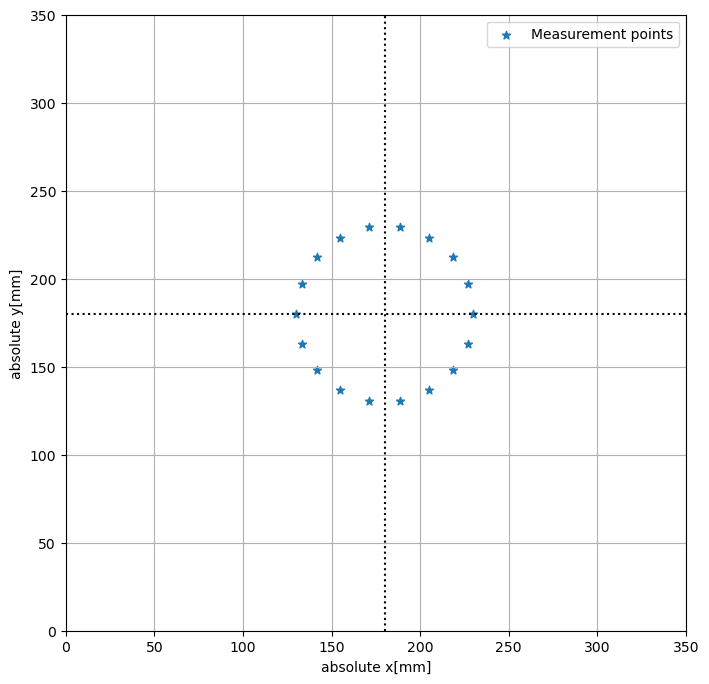

In [204]:
x,y = compute_abs_x_y_from_r_phi(50,20) # r = 50mm
plot_x_y_circle(x,y)

In [205]:
for x_step,y_step in zip(x,y):
    move_to_absolute_x_y(x_step, y_step)
    print(f"Start/Stop Measure at P({np.round(x_step,2)},{np.round(y_step,2)}).")
    
print("Finished")

b'ok\n'
Start/Stop Measure at P(230.0,180.0).
b'ok\n'
Start/Stop Measure at P(226.98,197.1).
b'ok\n'
Start/Stop Measure at P(218.3,212.14).
b'ok\n'
Start/Stop Measure at P(205.0,223.3).
b'ok\n'
Start/Stop Measure at P(188.68,229.24).
b'ok\n'
Start/Stop Measure at P(171.32,229.24).
b'ok\n'
Start/Stop Measure at P(155.0,223.3).
b'ok\n'
Start/Stop Measure at P(141.7,212.14).
b'ok\n'
Start/Stop Measure at P(133.02,197.1).
b'ok\n'
Start/Stop Measure at P(130.0,180.0).
b'ok\n'
Start/Stop Measure at P(133.02,162.9).
b'ok\n'
Start/Stop Measure at P(141.7,147.86).
b'ok\n'
Start/Stop Measure at P(155.0,136.7).
b'ok\n'
Start/Stop Measure at P(171.32,130.76).
b'ok\n'
Start/Stop Measure at P(188.68,130.76).
b'ok\n'
Start/Stop Measure at P(205.0,136.7).
b'ok\n'
Start/Stop Measure at P(218.3,147.86).
b'ok\n'
Start/Stop Measure at P(226.98,162.9).
